In [103]:
import re
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tiktoken
from tqdm import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [104]:
@dataclass(frozen=True)
class Config:
    text_path = 'dataset/sherlock-holm.es_stories_plain-text_advs.txt'
    max_length = 64
    stride = 4
    batch_size = 96

cfg = Config()

In [105]:
# 전처리 및 토크나이즈
with open(cfg.text_path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

# 줄 앞뒤 공백 제거 및 연속된 빈 줄 1개로 정리
raw_text = re.sub(r'\s+\n', '\n', raw_text)
raw_text = re.sub(r'^\s+', '', raw_text, flags=re.MULTILINE)
raw_text = re.sub(r'\n{2,}', '\n\n', raw_text)

# 제목 삭제
raw_text = re.sub(r'THE ADVEN.*\n', '', raw_text, flags=re.MULTILINE)

# 목차나 저자 등 메타데이터 제거
raw_text = re.sub(r'Arthur Conan Doyle', '', raw_text, flags=re.IGNORECASE)
raw_text = re.sub(r'\bTable of contents\b.*?(?=CHAPTER I)', '', raw_text, flags=re.DOTALL|re.IGNORECASE)
raw_text = re.sub(r'chapter ([0~9]|[ivx])', '', raw_text, flags=re.IGNORECASE)
raw_text = re.sub(r'----.*', '', raw_text, flags=re.DOTALL)


# 특수문자, 과도한 빈칸 정리
raw_text = re.sub(r'[“”]', '"', raw_text)
raw_text = re.sub(r"[‘’]", "'", raw_text)
raw_text = re.sub(r' +', ' ', raw_text)

# 앞뒤 전체 공백 제거
raw_text = raw_text.strip()

# 전처리된 텍스트 결과
preprocessed_text = raw_text
print(f"preprocessed text length: {len(preprocessed_text)}, words: {len(preprocessed_text.split())}")

# 토크나이저 초기화
tokenizer = tiktoken.get_encoding("gpt2")

# 토크나이즈
tokenized_text = tokenizer.encode(preprocessed_text)
print(len(tokenized_text))

preprocessed text length: 558453, words: 104321
142064


In [106]:
class MyDataset(Dataset) :
    def __init__(self, tokenized_text, cfg) :
        self.tokenized_text = tokenized_text
        self.cfg = cfg
        
        self.input_ids = []
        self.labels = []
        
        for i in range(0, len(self.tokenized_text) - self.cfg.max_length, self.cfg.stride) :
            self.input_ids.append(self.tokenized_text[i:i+self.cfg.max_length])
            self.labels.append(self.tokenized_text[i+1:i+self.cfg.max_length+1])
        
        self.input_ids = torch.tensor(self.input_ids)
        self.labels = torch.tensor(self.labels)
        
    def __len__(self) :
        return len(self.input_ids)

    def print(self) :
        return self.input_ids[1], self.labels[1]
    
    def __getitem__(self, idx) :
        return self.input_ids[idx], self.labels[idx]

In [107]:
test = MyDataset(tokenized_text, cfg)
test.print()

(tensor([  318,  1464,   262,  2415,    13,   314,   423, 25129,  2982,   683,
           198,   434,   295,   607,   739,   597,   584,  1438,    13,   554,
           465,  2951,   673, 39097,   274,   290,   198, 28764,  6351,   689,
           262,  2187,   286,   607,  1714,    13,   632,   373,   407,   326,
           339,  2936,   597,   198,   368,  9650, 22107,   284,  1842,   329,
          7181,   710,  1215,  1754,    13,  1439, 10825,    11,   290,   326,
           530,   198, 31722,    11]),
 tensor([ 1464,   262,  2415,    13,   314,   423, 25129,  2982,   683,   198,
           434,   295,   607,   739,   597,   584,  1438,    13,   554,   465,
          2951,   673, 39097,   274,   290,   198, 28764,  6351,   689,   262,
          2187,   286,   607,  1714,    13,   632,   373,   407,   326,   339,
          2936,   597,   198,   368,  9650, 22107,   284,  1842,   329,  7181,
           710,  1215,  1754,    13,  1439, 10825,    11,   290,   326,   530,
           19

모델 참조 : https://www.manning.com/books/build-a-large-language-model-from-scratch

In [108]:
VOCAB_SIZE = tokenizer.n_vocab
print(VOCAB_SIZE)
#VOCAB_SIZE = len(tokenizer) # AutoTokenizer
L = 128  # Shortened context length (orig: 1024)
E = 768  # Embedding dimension
H = 12  # Number of attention heads
NUM_LAYERS = 6  # Number of layers
DROP_RATE = 0.1  # Dropout rate

50257


In [109]:
class MultiheadAttention(nn.Module) :
    def __init__(self, din, dout) :
        super().__init__()
        
        assert dout % H == 0, "dout must be devided by NUM_HEADS"
        
        self.din = din
        self.dout = dout
        self.D = dout // H
        
        self.W_Q = nn.Linear(din, dout)
        self.W_K = nn.Linear(din, dout)
        self.W_V = nn.Linear(din, dout)
        self.out_proj = nn.Linear(dout, dout)
        self.dropout = nn.Dropout(p=DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(L, L), diagonal=1)) # Causal Attn을 위한 Mask
        
    def forward(self, x) :
        B, L, E = x.shape
        D = self.D
        
        # Query, Key, Value Matrix 생성 (B, L, E)
        Q = self.W_Q(x)
        K = self.W_K(x)
        V = self.W_V(x)
        
        # Multihead 반영 (B, L, E) -> (B, L, H, D) -> (B, H, L, D)
        Q = Q.view(B, L, H, D).transpose(1, 2)
        K = K.view(B, L, H, D).transpose(1, 2)
        V = V.view(B, L, H ,D).transpose(1, 2)
        
        # Attention Score 구하기
        attn_scores = Q @ K.transpose(2, 3) # (B, H, L, L)
        mask = self.mask[:L, :L].bool()
        attn_scores = attn_scores.masked_fill(mask, -1e9)
        attn_scores = attn_scores / (D ** 0.5)
        
        # Attention Weight 구하기
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Context Vector 구하기
        CV = attn_weights @ V # (B, H, L, D)
        CV = CV.transpose(1, 2).contiguous().view(B, L, E)
        CV = self.out_proj(CV)
        
        return CV
    
class LayerNorm(nn.Module) :
    def __init__(self, dim, eps=1e-5) :
        super().__init__()
        
        # 파라미터 생성
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def forward(self, x) :
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x = (x - mean) / torch.sqrt(var + self.eps) * self.gamma + self.beta
        return x

class FeedForward(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(E, 4*E),
            nn.GELU(),
            nn.Linear(4*E, E),
        )
    
    def forward(self, x) :
        x = self.layers(x)
        return x
    
class TransformerBlock(nn.Module) :
    def __init__(self):
        super().__init__()
        self.attn = MultiheadAttention(E, E)
        self.norm1 = LayerNorm(E)
        self.norm2 = LayerNorm(E)
        self.ff = FeedForward()
        self.dropout = nn.Dropout(DROP_RATE)
        
    def forward(self, x):
        residual = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + residual
        
        residual = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + residual
        
        return x
    
class SimpleLLM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.token_embedding = nn.Embedding(VOCAB_SIZE, E)
        self.positional_embedding = nn.Embedding(L, E)
        self.dropout_embedding = nn.Dropout(DROP_RATE)
        
        self.blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)]
        )
        
        self.last_norm = LayerNorm(E)
        self.out = nn.Linear(E, VOCAB_SIZE, bias=False)
        
    def forward(self, input_ids) :
        B, L = input_ids.shape
        tok_emb = self.token_embedding(input_ids)
        pos_emb = self.positional_embedding(torch.arange(L, device=input_ids.device))
        x = tok_emb + pos_emb
        x = self.dropout_embedding(x)
        x = self.blocks(x)
        x = self.last_norm(x)
        logits = self.out(x)
        return logits

In [ ]:
# 모델 학습

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(42)
model = SimpleLLM().to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4, weight_decay=0.01)
train_dataset = MyDataset(tokenized_text, cfg)
train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, num_workers=8, pin_memory=True, shuffle=True)

num_epochs = 50

epoch_losses = []
for epoch in range(num_epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"[Epoch : {epoch + 1}]")
    
    epoch_loss = 0
    for input_ids, labels in pbar:
        optimizer.zero_grad()
        input_ids, labels = input_ids.to(device), labels.to(device) # (B, L)
        
        logits = model(input_ids) # (B, L, V)
        loss = F.cross_entropy(logits.flatten(0, 1), labels.flatten())
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.set_postfix(loss=loss.item())
    
    avg_loss = epoch_loss / len(pbar)
    epoch_losses.append(avg_loss)
    print(f"Avg Loss : {avg_loss}")
    torch.save(model.state_dict(), f"model/simplellm_epoch{epoch+1}.pth")

cuda


[Epoch : 1]: 100%|██████████| 370/370 [01:42<00:00,  3.62it/s, loss=2.85]


Avg Loss : 4.434826627293148


[Epoch : 2]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.672]


Avg Loss : 1.6000405967235565


[Epoch : 3]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.284]


Avg Loss : 0.3873643256522514


[Epoch : 4]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.215]


Avg Loss : 0.22701506514001538


[Epoch : 5]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.19] 


Avg Loss : 0.1819407149343877


[Epoch : 6]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.163]


Avg Loss : 0.15960212176716004


[Epoch : 7]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.155]


Avg Loss : 0.1472369960433728


[Epoch : 8]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.148]


Avg Loss : 0.13801623172051197


[Epoch : 9]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.139]


Avg Loss : 0.13253490220050554


[Epoch : 10]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.145]


Avg Loss : 0.1269838837554326


[Epoch : 11]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.123]


Avg Loss : 0.12325755836995872


[Epoch : 12]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.13] 


Avg Loss : 0.12019976431856284


[Epoch : 13]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.126]


Avg Loss : 0.11790154028583218


[Epoch : 14]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.126] 


Avg Loss : 0.11494085307459573


[Epoch : 15]: 100%|██████████| 370/370 [01:43<00:00,  3.56it/s, loss=0.12] 


Avg Loss : 0.11305300539007059


[Epoch : 16]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.114] 


Avg Loss : 0.11149368743236


[Epoch : 17]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.115] 


Avg Loss : 0.10955652489855483


[Epoch : 18]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.107] 


Avg Loss : 0.10773113818990218


[Epoch : 19]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.111] 


Avg Loss : 0.10638316036076159


[Epoch : 20]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.119] 


Avg Loss : 0.10509153483687221


[Epoch : 21]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.113] 


Avg Loss : 0.10352847223749032


[Epoch : 22]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.113] 


Avg Loss : 0.10290500851901802


[Epoch : 23]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.114] 


Avg Loss : 0.1020241076680454


[Epoch : 24]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.103] 


Avg Loss : 0.10104626846071836


[Epoch : 25]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.107] 


Avg Loss : 0.0999959820025676


[Epoch : 26]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.107] 


Avg Loss : 0.098749515957929


[Epoch : 27]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.104] 


Avg Loss : 0.09839380983565305


[Epoch : 28]: 100%|██████████| 370/370 [01:43<00:00,  3.59it/s, loss=0.0987]


Avg Loss : 0.09787648714877464


[Epoch : 29]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.108] 


Avg Loss : 0.09730466032350385


[Epoch : 30]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.099] 


Avg Loss : 0.09603759368529191


[Epoch : 31]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.0944]


Avg Loss : 0.09563091310697633


[Epoch : 32]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.091] 


Avg Loss : 0.09547921425184688


[Epoch : 33]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.101] 


Avg Loss : 0.09432954109601073


[Epoch : 34]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.103] 


Avg Loss : 0.09415597841143608


[Epoch : 35]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.0984]


Avg Loss : 0.09419406219511418


[Epoch : 36]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.0985]


Avg Loss : 0.09306228821342055


[Epoch : 37]: 100%|██████████| 370/370 [01:43<00:00,  3.58it/s, loss=0.098] 


Avg Loss : 0.0926113131682615


[Epoch : 38]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.0938]


Avg Loss : 0.09221814919162441


[Epoch : 39]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.0978]


Avg Loss : 0.09228985337792216


[Epoch : 40]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.1]   


Avg Loss : 0.09156868572573404


[Epoch : 41]: 100%|██████████| 370/370 [01:43<00:00,  3.57it/s, loss=0.0945]


Avg Loss : 0.09134422476227219


[Epoch : 42]:  38%|███▊      | 141/370 [00:39<01:03,  3.59it/s, loss=0.0933]

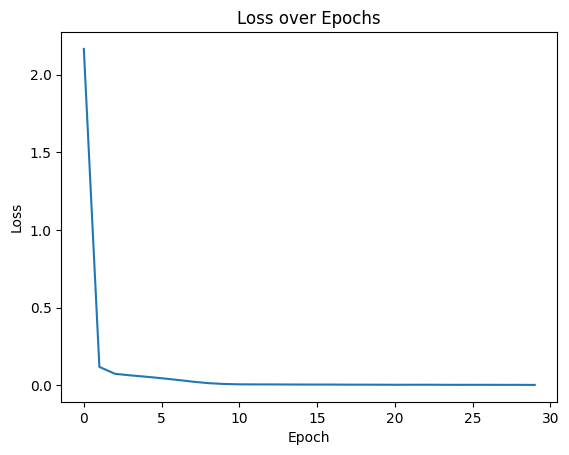

In [44]:
# 학습 결과 출력
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

In [102]:
# 문장 생성

# 모델 불러오기
model.load_state_dict(torch.load('./model/simplellm_epoch30.pth', map_location=device, weights_only=True))
model.eval()

text = "My name " # 시작 문장

input_ids = tokenizer.encode(text)
input_ids = torch.tensor(input_ids).unsqueeze(0) # (1, L)
input_ids = input_ids.to(device)

repetition_penalty = 2.0  # ★ 추가 (1.1~1.5 보통)

generation_len = 10
for _ in range(generation_len):
    with torch.no_grad():
        logits = model(input_ids)  # (1, L, V)

    logits = logits[:, -1, :]     # (1, V)
    logits = logits / 0.5         # temperature

    # ★ repetition penalty 적용
    for token_id in set(input_ids[0].tolist()):
        logits[0, token_id] /= repetition_penalty

    next_token = torch.argmax(logits, dim=-1, keepdim=True)  # (1, 1)
    input_ids = torch.cat((input_ids, next_token), dim=-1)

    
input_ids = input_ids.squeeze(0) # (Generation_Len, )
generated_text = tokenizer.decode(input_ids.tolist())

print(generated_text)

My name  please time I'll forehead five minutes.' Heaven bless


In [77]:
idx = tokenizer.encode("The evidence was") # 토큰 id의 list
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10) 
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)


12.35	 2370	  evidence
11.92	 373	  was
10.76	 2166	  front
10.75	 6178	  adm
10.59	 4692	  cold
10.46	 2696	 ises
10.43	 7932	  wonderful
10.40	 7954	  angry
10.23	 26347	  speeding
10.06	 12000	  seized
 evidence
